# **INITIALIZATION**

Import libraries.

In [1]:
# Library for reading and writing data to and from files
import os
# Library for getting dictionaries from data structures
from collections import defaultdict
import pandas as pd
from collections import defaultdict

Define paths.

In [2]:
# Dataset directory
corpus_directory='../Dataset/corpus2mw'

To iterate the reading procedure, get the names of the documents in the dataset.

In [3]:
# Get a list with the names of the documents
texts_names = os.listdir(corpus_directory)

# **GET TOKENS**

First, define the special characters to be separated from each word.

In [4]:
# List of characters
specialchars = [';', ':', '!', '?', '<', '>', '&', ')', '(', ']', '[', ',', '.', '"', '%', '$ ', '=', '}', '{', '-']

And define the function which separates the special characters from each word, assuming they can only be before or after each word.

In [5]:
def token(w):
    # Init the empty list of tokens
    res = []

    # If the length is 1, add the character whatever it is
    if len(w) == 1:
        res.append(w)
    
    # Otherwise (if it's at least two characters)
    else:
        # If the first character is special, add it to the list and remove it from the word
        if w[0] in specialchars:
            res.append(w[0])
            w = w[1:]
        
        # Now, if the length became 1 because of that, for the same reason as before, add the character whatever it is
        if len(w) == 1:
            res.append(w)
        # Otherwise (if it's at least two characters), both if I had removed the first or not
        # Check whether the last character is special
        elif w[-1] in specialchars:
            res.append(w[:-1])
            res.append(w[-1])
        # or not
        else:
            res.append(w)
        
    # Return the list of tokens
    return res

For each document, for each word (in each line), if either the last or the first character are specialchars, then split in multiple tokens.

In [6]:
corpus = []
corpus_lens = []

# For each document in the directory
for text in texts_names:

    # Init a temp empty list for the words in the current document
    words = []

    # Open the document
    with open(corpus_directory + '/' + text, 'r', errors='ignore') as file:

        # For each line
        for line in file:
            # For each word in the line
            for word in line.split():
                # Tokenize it
                aux = token(word)
                # And add each token to the list of words
                for t in aux:
                    words.append(t.lower())
    # Then append the list of tokens for the document in the corpus list
    corpus.append(words)
    corpus_lens.append(len(words))

# **STOP WORDS**

Define the function to find the stop words.

In [46]:
# Returns the extracted stop words
def get_stop_words(param=4,d=1):

    # Initialize a dictionary for sets
    neighbour_counts = defaultdict(set)

    # For each document in the corpus
    for doc in corpus:
        # For each word in the document
        for idx in range(len(doc)):
            # If the word is not the first word, add the previous word to its set of neighbours
            if idx > 0:
                neighbour_counts[doc[idx]].add(doc[idx - 1])
            # If the word is not the last word, add the next word to its set of neighbours
            if idx < len(doc) - 1:
                neighbour_counts[doc[idx]].add(doc[idx + 1])

    # Convert the sets of neighbours to counts of unique neighbours
    for word, neighbours in neighbour_counts.items():
        neighbour_counts[word] = len(neighbours)

    # Sort the words by their counts of unique neighbours
    neighbour_counts = sorted(neighbour_counts.items(), key=lambda item: item[1], reverse=True)

    # Remove from the neighbour_counts list the words that are special chars
    for special in specialchars:
        neighbour_counts = [tuple for tuple in neighbour_counts if tuple[0] != special]
    
    # Now look for the elbow point in the list
    elbow_point_index = 0
    # Iterate over the list (besides last word) to find the elbow point
    for index in range(len(neighbour_counts) - 1 - param):
        # Get the difference between the count for the current word and the next
        if abs(neighbour_counts[index][1] - neighbour_counts[index + param][1]) * d < param:
            elbow_point_index = index - 1
            break
    
    # Get the couples corresponding to all the words up to the elbow (highest num of neighbours)
    stop_word_counts = neighbour_counts[:elbow_point_index+1]
    # Get the stop words
    stop_words = [tuple[0] for tuple in stop_word_counts]
    
    # Return the stop words and the filtered expressions
    return stop_words

In [48]:
def neighbour_counts():

    # Initialize a dictionary for sets
    neighbour_counts = defaultdict(set)

    # For each document in the corpus
    for doc in corpus:
        # For each word in the document
        for idx in range(len(doc)):
            # If the word is not the first word, add the previous word to its set of neighbours
            if idx > 0:
                neighbour_counts[doc[idx]].add(doc[idx - 1])
            # If the word is not the last word, add the next word to its set of neighbours
            if idx < len(doc) - 1:
                neighbour_counts[doc[idx]].add(doc[idx + 1])

    # Convert the sets of neighbours to counts of unique neighbours
    for word, neighbours in neighbour_counts.items():
        neighbour_counts[word] = len(neighbours)

    # Sort the words by their counts of unique neighbours
    neighbour_counts = sorted(neighbour_counts.items(), key=lambda item: item[1], reverse=True)

    # Remove from the neighbour_counts list the words that are special chars
    for special in specialchars:
        neighbour_counts = [tuple for tuple in neighbour_counts if tuple[0] != special] 

    return neighbour_counts

In [49]:
nei = neighbour_counts()

And compute them.

In [26]:
# Define the ranges for param and d
param_values = range(1, 7)
d_values = [1/3, 1/2, 1, 2, 3]

# Initialize an empty list to store the results
results = []

# Iterate over all combinations of param and d
for param in param_values:
    for d in d_values:
        # Get the stop words for the current combination of param and d
        stop_words = get_stop_words(param, d)
        # Append the result as a tuple (param, d, number of stop words)
        results.append((param, d, len(stop_words)))

# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['param', 'd', 'num_stop_words'])

# Pivot the DataFrame to create the desired table
pivot_df = df.pivot(index='d', columns='param', values='num_stop_words')

# Display the pivoted DataFrame
print(pivot_df)

[('the', 28312), ('and', 26112), ('of', 20895), ('in', 16628), ('to', 12515), ('a', 11378), ('was', 8664), ('is', 8165), ('for', 7703), ('by', 7589)]
[('the', 28312), ('and', 26112), ('of', 20895), ('in', 16628), ('to', 12515), ('a', 11378), ('was', 8664), ('is', 8165), ('for', 7703), ('by', 7589)]
[('the', 28312), ('and', 26112), ('of', 20895), ('in', 16628), ('to', 12515), ('a', 11378), ('was', 8664), ('is', 8165), ('for', 7703), ('by', 7589)]
[('the', 28312), ('and', 26112), ('of', 20895), ('in', 16628), ('to', 12515), ('a', 11378), ('was', 8664), ('is', 8165), ('for', 7703), ('by', 7589)]
[('the', 28312), ('and', 26112), ('of', 20895), ('in', 16628), ('to', 12515), ('a', 11378), ('was', 8664), ('is', 8165), ('for', 7703), ('by', 7589)]
[('the', 28312), ('and', 26112), ('of', 20895), ('in', 16628), ('to', 12515), ('a', 11378), ('was', 8664), ('is', 8165), ('for', 7703), ('by', 7589)]
[('the', 28312), ('and', 26112), ('of', 20895), ('in', 16628), ('to', 12515), ('a', 11378), ('was', 

In [32]:
import numpy as np
import plotly.graph_objs as go
from scipy.interpolate import griddata

# Define x, y, z values
param = np.arange(1, 7)
d = np.array(d_values)

stop_words = np.array([
    [26, 76, 83, 94, 94, 119],
    [40, 84, 94, 94, 121, 121],
    [61, 84, 123, 154, 154, 154],
    [61, 224, 176, 250, 176, 250],
    [61, 224, 284, 250, 284, 284]
])

# Create meshgrid for x and y
X, Y = np.meshgrid(param, d)

# Interpolate z values to complete grid
X_new = np.linspace(param.min(), param.max(), 100)
Y_new = np.linspace(d.min(), d.max(), 100)
X_new, Y_new = np.meshgrid(X_new, Y_new)
Z_new = griddata((X.flatten(), Y.flatten()), stop_words.flatten(), (X_new, Y_new), method='cubic')

# Scatter plot
scatter = go.Scatter3d(
    x=X.flatten(),
    y=Y.flatten(),
    z=stop_words.flatten(),
    mode='markers',
    marker=dict(
        size=4,
        color='rgb(23, 190, 207)',
        opacity=0.8
    )
)

# Surface plot
surface = go.Surface(
    x=X_new,
    y=Y_new,
    z=Z_new,
    colorscale='Viridis',
)

# Add point (4,1,F(4,1))
point = go.Scatter3d(
    x=[4],
    y=[1],
    z=[154],
    mode='markers',
    marker=dict(
        size=10,
        color='red',
        opacity=0.8
    )
)

# Layout
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='param'),
        yaxis=dict(title='d'),
        zaxis=dict(title='Number of stop words'),
        aspectratio=dict(x=1, y=1, z=0.7),
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    )
)

# Create figure
fig = go.Figure(data=[scatter, surface, point], layout=layout)





In [33]:
import plotly.io as pio

# Salva il grafico come file HTML
pio.write_html(fig, '3d_plot_grande.html')

# Visualizza il percorso del file HTML
print("Il file HTML è stato salvato con successo. Puoi aprirlo nel tuo browser.")

Il file HTML è stato salvato con successo. Puoi aprirlo nel tuo browser.


In [ ]:
# Get stop words
stop_words = get_stop_words()
print(len(stop_words))
print(stop_words)

# And write them all on file
with open('../Output/stop_words.txt', 'w') as f:
    for word in stop_words:
        f.write("\"")
        f.write(word)
        f.write("\"")
        f.write(', ')
del corpus

[('the', 252231), ('of', 120104), ('and', 102111), ('in', 99559), ('a', 73020), ('to', 72052), ('was', 42182), ('is', 35760), ('for', 29332), ('on', 28481)]
242
['the', 'of', 'and', 'in', 'a', 'to', 'was', 'is', 'for', 'on', 'as', 'with', 'by', 'he', 'that', 'at', 'from', 'his', 'it', 'an', 'were', 'are', 'which', 'doc', 'this', 'also', 'be', 'or', 'has', 'had', 'first', 'their', 'one', 'but', 'its', 'after', 'not', 'new', 'they', 'who', 'have', 'two', 'her', 'she', 'been', 'other', 'when', 'during', 'there', 'into', 'all', 'time', 'more', 'only', 'may', 'most', 'school', 'years', 'would', 'over', 'some', 'out', 'such', 'national', 'up', 'him', 'later', 'about', 'used', 'where', 'between', 'world', 'then', 'city', 'many', 'can', 'made', 'three', 'while', 'state', 'year', 'under', 'known', 'part', 'these', 'united', 'than', 'university', 'second', 'being', 'became', 'no', 'american', 'season', 'before', 'both', 'team', 'states', 'through', 'however', 'war', 'including', 'early', 'born',

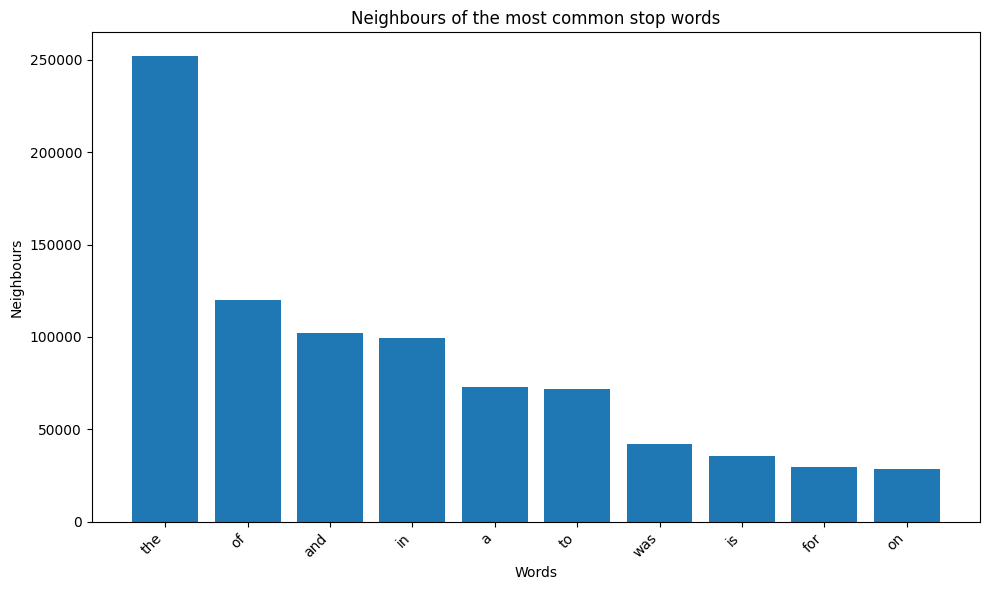

In [ ]:
import matplotlib.pyplot as plt

# Dati forniti
data = [('the', 252231), ('of', 120104), ('and', 102111), ('in', 99559), ('a', 73020), ('to', 72052), ('was', 42182), ('is', 35760), ('for', 29332), ('on', 28481)]

# Estrai valori e etichette
labels, values = zip(*data)

# Creazione del plot
plt.figure(figsize=(10, 6))  # Imposta dimensioni della figura
plt.bar(range(1, len(labels) + 1), values, tick_label=labels)  # Crea un grafico a barre
plt.xlabel('Words')  # Etichetta dell'asse x
plt.ylabel('Neighbours')  # Etichetta dell'asse y
plt.title('Neighbours of the most common stop words')  # Titolo del grafico
plt.xticks(rotation=45, ha='right')  # Ruota le etichette sull'asse x per una migliore leggibilità
plt.tight_layout()  # Imposta il layout in modo che le etichette non si sovrappongano
plt.show()  # Mostra il grafico


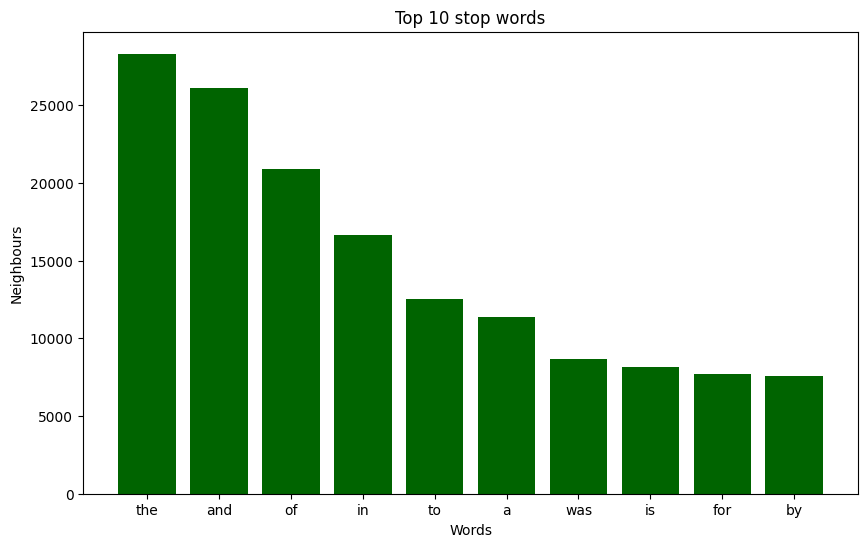

In [35]:
import matplotlib.pyplot as plt

# Define the data
words = ['the', 'and', 'of', 'in', 'to', 'a', 'was', 'is', 'for', 'by']
frequencies = [28312, 26112, 20895, 16628, 12515, 11378, 8664, 8165, 7703, 7589]

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='darkgreen')
plt.xlabel('Words')
plt.ylabel('Neighbours')
plt.title('Top 10 stop words')
plt.show()


[28312, 26112, 20895, 16628, 12515, 11378, 8664, 8165, 7703, 7589, 7291, 6346, 6232, 5892, 5794, 5091, 4807, 4318, 4036, 3920, 3842, 2891, 2683, 2515, 2465, 2366, 2188, 2186, 2099, 1962, 1927, 1870, 1826, 1746, 1717, 1712, 1697, 1693, 1660, 1624, 1573, 1572, 1562, 1553, 1381, 1372, 1369, 1296, 1283, 1279, 1273, 1233, 1230, 1222, 1204, 1203, 1160, 1154, 1116, 1104, 1103, 1070, 1070, 1061, 1060, 1038, 1027, 1021, 985, 982, 974, 970, 949, 949, 936, 923, 900, 897, 896, 891, 877, 873, 852, 845, 839, 839, 838, 829, 808, 805, 802, 792, 791, 783, 770, 770, 768, 766, 764, 758, 726, 720, 716, 696, 691, 691, 681, 680, 680, 676, 659, 653, 645, 643, 635, 630, 628, 627, 615, 608, 608, 604, 600, 597, 597, 596, 595, 593, 591, 583, 570, 569, 568, 566, 556, 552, 546, 545, 541, 540, 539, 537, 536, 534, 529, 523, 520, 512, 509, 506, 506, 505, 504, 502, 499, 499, 498, 496, 496, 495, 494, 494, 491, 490, 487, 487, 485, 483, 481, 480, 479, 478, 476, 475, 475, 468, 465, 465, 464, 464, 463, 463, 458, 457, 454, 

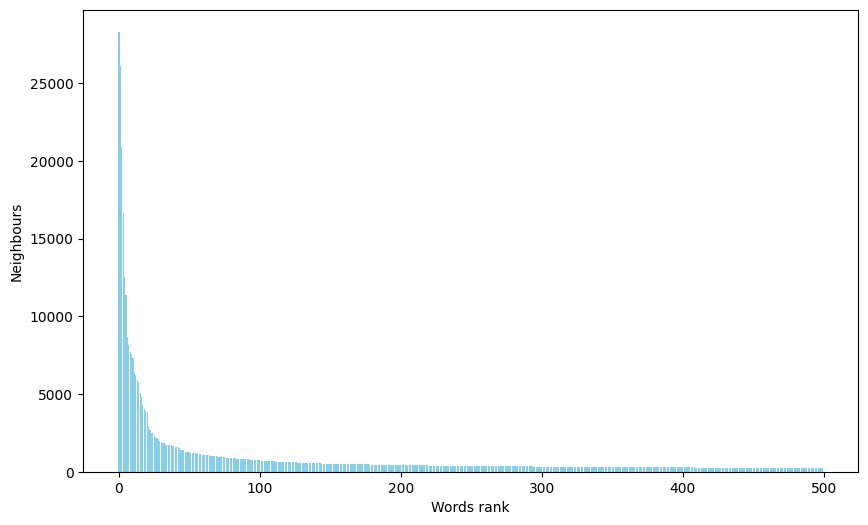

In [57]:
# Estrai solo i valori
values = [value for key, value in nei[:500]]

print(values)

# Crea l'istogramma
plt.figure(figsize=(10, 6))
plt.bar(range(len(values)), values, color='skyblue')
plt.xlabel('Words rank')
plt.ylabel('Neighbours')
plt.show()